In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from nilearn.plotting import plot_stat_map
import datalad.api as dl
import warnings
import nibabel as nib
from scipy.stats import ttest_rel


warnings.simplefilter('ignore')

## Load behavrioral data

In [3]:
pwd


'/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/QC_py310'

In [44]:
data_dir = '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/data/suggestion_block_concat_4D/ANA'
data_dir = '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/preproc_data/23subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/suggestion_blocks_concat_4D_23sub/ANA'
ana_files = glob.glob(os.path.join(data_dir, '*ANA*.nii.gz'))
# subjects = [os.path.basename(os.path.dirname(path)) for path in ana_files]
subjects = [os.path.basename(path)[:6] for path in ana_files]

project_dir = '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions'

behav_path = r"/data/rainville/dSutterlin/projects/resting_hypnosis/resting_state_hypnosis/atlases/Hypnosis_variables_20190114_pr_jc.xlsx"
APM_subjects = ['APM' + sub[4:] for sub in subjects] # make APMXX format instead of subXX


In [37]:
ana_files, APM_subjects



(['/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/preproc_data/23subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/suggestion_blocks_concat_4D_23sub/ANA/sub-20_87-vol_ANA.nii.gz',
  '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/preproc_data/23subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/suggestion_blocks_concat_4D_23sub/ANA/sub-43_87-vol_ANA.nii.gz',
  '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/preproc_data/23subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/suggestion_blocks_concat_4D_23sub/ANA/sub-26_87-vol_ANA.nii.gz',
  '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/preproc_data/23subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/suggestion_blocks_concat_4D_23sub/ANA/sub-33_87-vol_ANA.nii.gz',
  '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/preproc_data/23subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/sugge

In [10]:
!pip install openpyxl



In [72]:
import func
import importlib
importlib.reload(func) 

phenotype= func.load_process_y(behav_path,APM_subjects)
phenotype.head()

,SHSS_score,mean_VAS_Nana_int,mean_VAS_ana_int,mean_VAS_Nhyper_int,mean_VAS_hyper_int,mean_VAS_Nana_UnP,mean_VAS_ana_UnP,mean_VAS_Nhyper_UnP,mean_VAS_hyper_UnP,raw_change_ANA,raw_change_HYPER,total_chge_pain_hypAna,Chge_hypnotic_depth,Mental_relax_absChange,Automaticity_post_ind,Abs_diff_automaticity,SHSS_groups,auto_groups
APM20,11.0,58.666667,24.0,50.0,65.5,32.666667,7.0,33.0,58.0,-30.166667,20.25,50.416667,59.5,-33.5,57.0,29.0,2,1
APM43,6.0,74.0,78.5,65.666667,65.5,77.333333,78.5,73.0,74.5,2.833333,0.666667,-2.166667,0.0,-12.5,40.0,-11.0,1,0
APM26,3.0,83.333333,80.0,78.333333,80.5,86.333333,86.0,88.333333,90.0,-1.833333,1.916667,3.75,14.0,-25.5,29.0,22.0,0,1
APM33,3.0,38.0,30.0,38.0,36.5,38.333333,32.5,37.333333,41.5,-6.916667,1.333333,8.25,33.5,4.0,44.0,27.0,0,1
APM12,11.0,71.0,73.0,63.666667,78.0,72.0,73.5,64.666667,79.0,1.75,14.333333,12.583333,81.5,-19.0,61.5,55.5,2,2


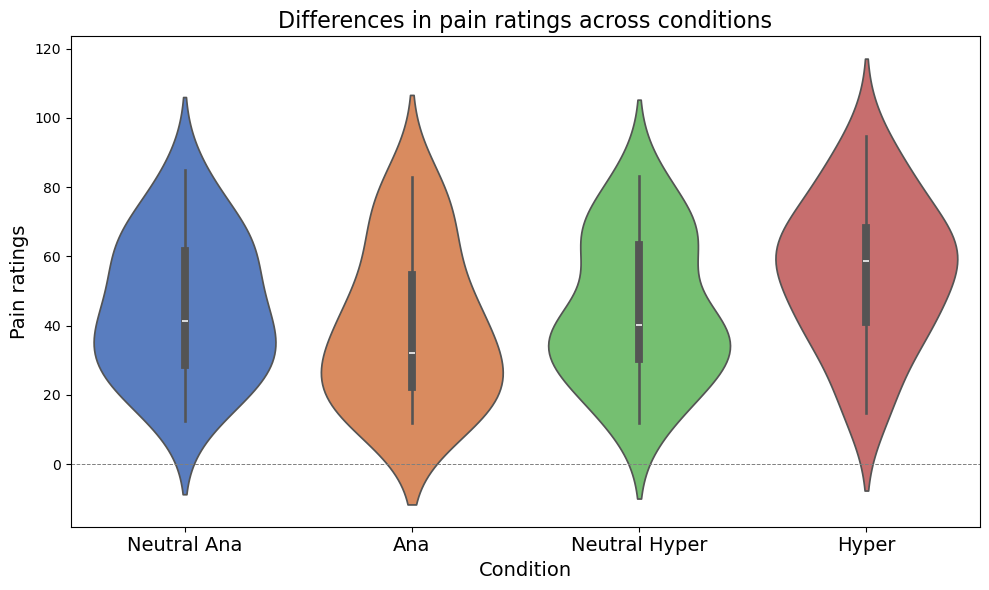

In [73]:
# Rename new columns
df = phenotype
df['mean_VAS_Nana'] = (df['mean_VAS_Nana_int'] + df['mean_VAS_Nana_UnP']) / 2
df['mean_VAS_Ana'] = (df['mean_VAS_ana_int'] + df['mean_VAS_ana_UnP']) / 2
df['mean_VAS_NHyper'] = (df['mean_VAS_Nhyper_int'] + df['mean_VAS_Nhyper_UnP']) / 2
df['mean_VAS_Hyper'] = (df['mean_VAS_hyper_int'] + df['mean_VAS_hyper_UnP']) / 2

# Perform t-tests
t_nana_ana, p_nana_ana = ttest_rel(df['mean_VAS_Nana'], df['mean_VAS_Ana'])
t_nhyper_hyper, p_nhyper_hyper = ttest_rel(df['mean_VAS_NHyper'], df['mean_VAS_Hyper'])
t_hyper_ana, p_hyper_ana = ttest_rel(df['mean_VAS_Hyper'], df['mean_VAS_Ana'])

# Prepare data for plotting with updated names
plot_df = pd.melt(
    df[['mean_VAS_Nana', 'mean_VAS_Ana', 'mean_VAS_NHyper', 'mean_VAS_Hyper']],
    var_name='Condition',
    value_name='VAS'
)

# Map new condition names for the plot
plot_df['Condition'] = plot_df['Condition'].map({
    'mean_VAS_Nana': 'Neutral Ana',
    'mean_VAS_Ana': 'Ana',
    'mean_VAS_NHyper': 'Neutral Hyper',
    'mean_VAS_Hyper': 'Hyper'
})

# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Condition', y='VAS', data=plot_df, inner='box', palette='muted')
plt.title('Differences in pain ratings across conditions', fontsize=16)
plt.ylabel('Pain ratings', fontsize=14)
plt.xlabel('Condition', fontsize=14)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)
plt.xticks(fontsize=14)

# Add statistics as DataFrame
stats_df = pd.DataFrame({
    'Comparison': ['Neutral Ana vs Ana', 'Neutral Hyper vs Hyper', 'Hyper vs Ana'],
    't-value': [t_nana_ana, t_nhyper_hyper, t_hyper_ana],
    'p-value': [p_nana_ana, p_nhyper_hyper, p_hyper_ana],
    'Mean 1': [df['mean_VAS_Nana'].mean(), df['mean_VAS_NHyper'].mean(), df['mean_VAS_Hyper'].mean()],
    'Mean 2': [df['mean_VAS_Ana'].mean(), df['mean_VAS_Hyper'].mean(), df['mean_VAS_Ana'].mean()],
    'Significant': [p_nana_ana < 0.05, p_nhyper_hyper < 0.05, p_hyper_ana < 0.05]
})

output_path = os.path.join(project_dir, 'results', "behavioral_ttest_pain_ratings_violin.png")
plt.savefig(output_path, bbox_inches='tight')

plt.tight_layout()
plt.show()


# Compute groups for pain and SHSS

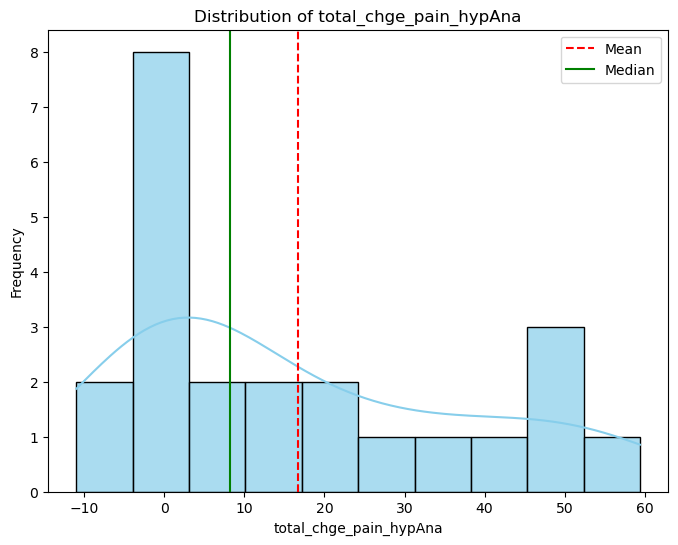

Mean :  16.63405797101449 and Median :  8.25


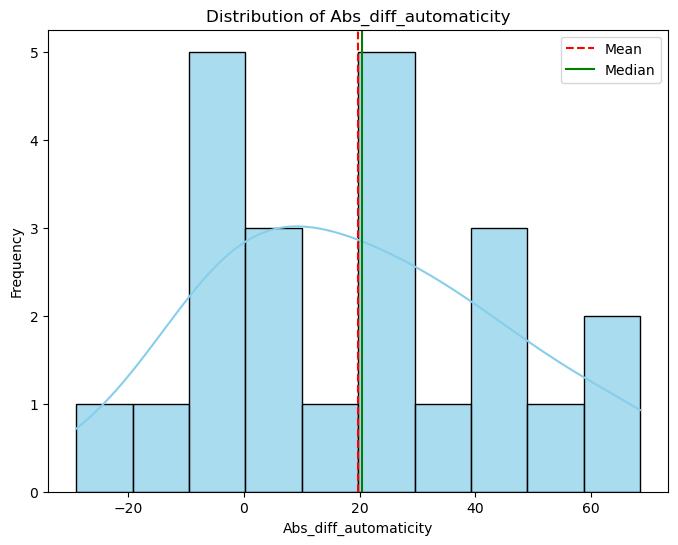

Mean :  19.649175412293854 and Median :  20.43103448275862


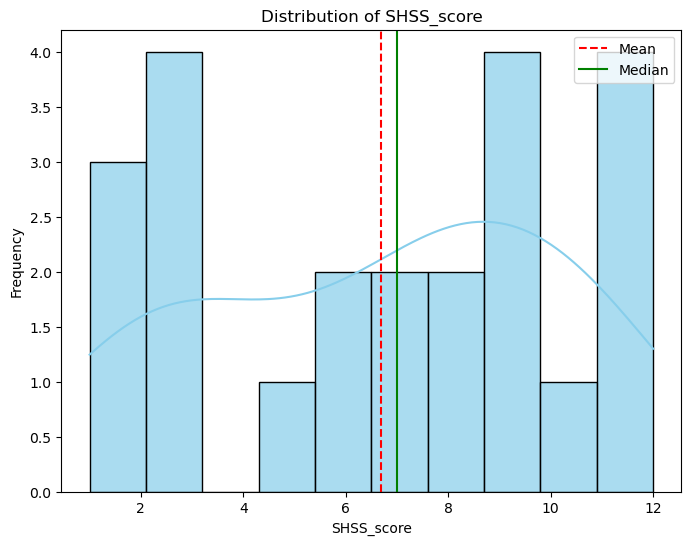

Mean :  6.695652173913044 and Median :  7.0


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Variables to plot
y_target = ['total_chge_pain_hypAna', 'Abs_diff_automaticity', 'SHSS_score']

# Plotting function
def plot_distribution(df, variables):
    for var in variables:
        plt.figure(figsize=(8, 6))
        sns.histplot(df[var], kde=True, bins=10, color="skyblue", alpha=0.7)
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.axvline(df[var].mean(), color='red', linestyle='--', label='Mean')
        plt.axvline(df[var].median(), color='green', linestyle='-', label='Median')
        plt.legend()
        plt.show()
        print('Mean : ', df[var].mean(), 'and Median : ', df[var].median())
        
# Call the plotting function
plot_distribution(df, y_target)


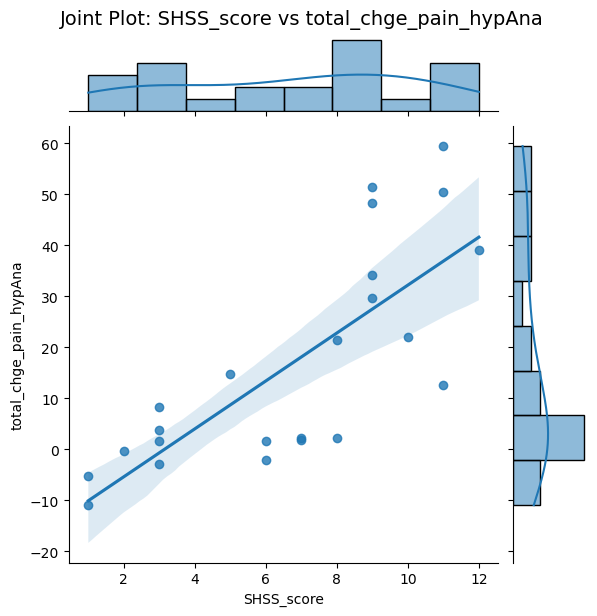

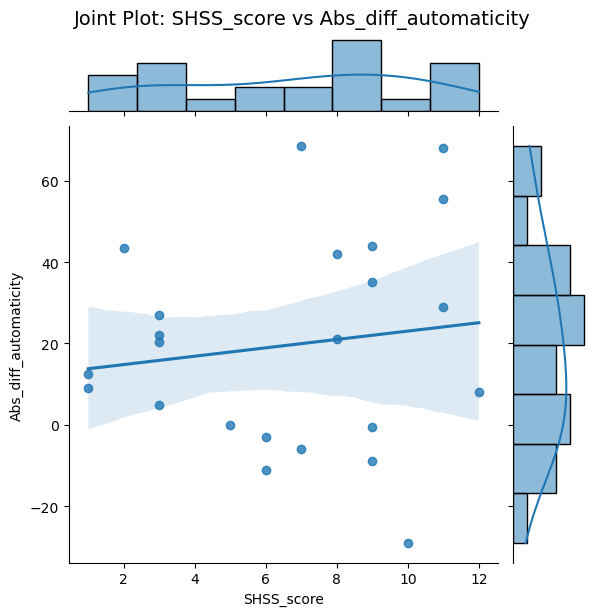

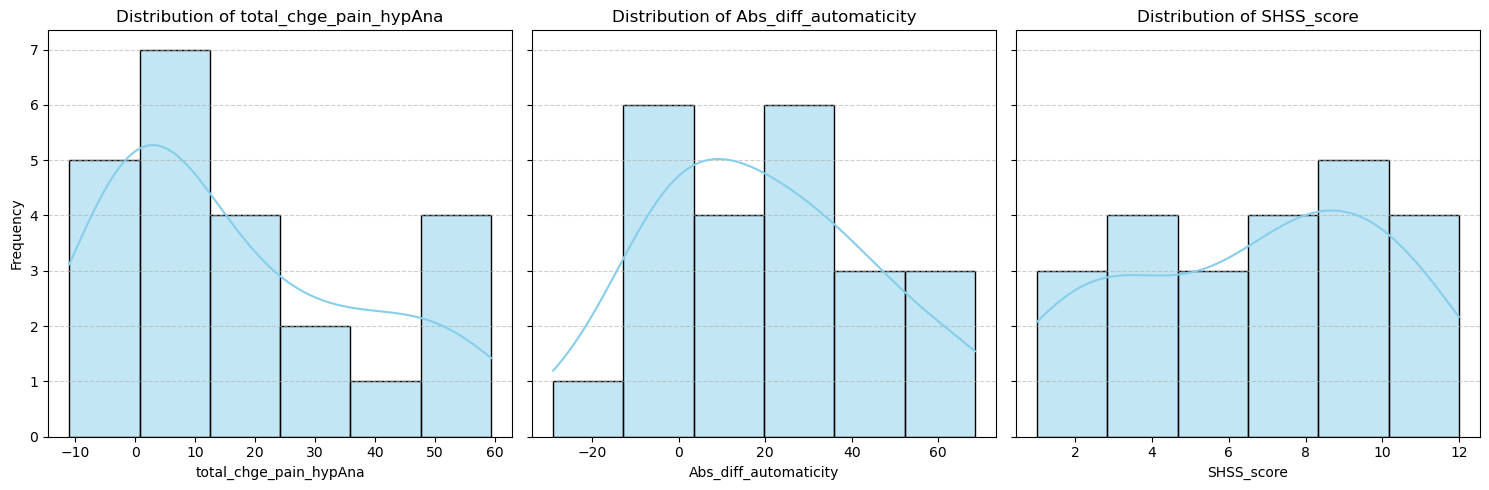

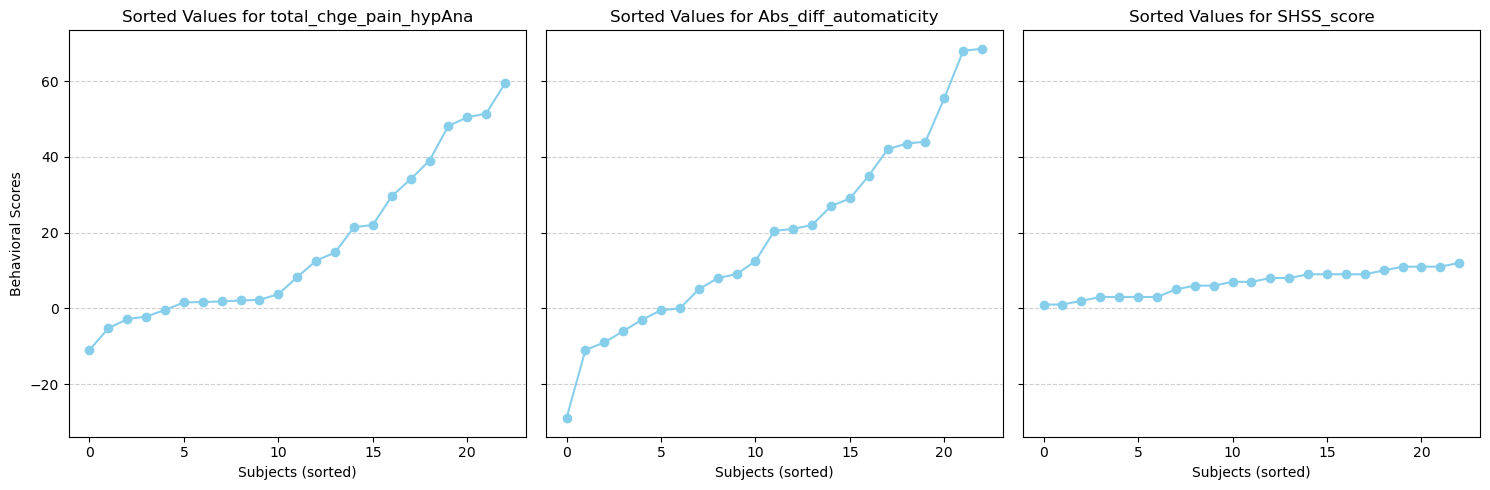

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Ensure all columns are numeric
df = df.astype(float)

# Variables to plot
variables = ['total_chge_pain_hypAna', 'Abs_diff_automaticity', 'SHSS_score']

# Combined histogram subplots
def plot_combined_histograms(df, variables, bins=6):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for i, var in enumerate(variables):
        sns.histplot(df[var], kde=True, bins=bins, color="skyblue", ax=axes[i])
        axes[i].set_title(f"Distribution of {var}", fontsize=12)
        axes[i].set_xlabel(var, fontsize=10)
        axes[i].set_ylabel('Frequency' if i == 0 else '', fontsize=10)
        axes[i].grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Compact subject-level plots
def plot_subject_lines(df, variables):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for i, var in enumerate(variables):
        # Sort subjects by value
        sorted_data = df.sort_values(by=var).reset_index()
        axes[i].plot(sorted_data.index, sorted_data[var], marker='o', linestyle='-', color='skyblue')
        axes[i].set_title(f'Sorted Values for {var}', fontsize=12)
        axes[i].set_xlabel('Subjects (sorted)', fontsize=10)
        if i == 0:
            axes[i].set_ylabel('Behavioral Scores', fontsize=10)
        axes[i].grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_jointplots(df, x_var, y_vars):
    for y_var in y_vars:
        g = sns.jointplot(
            data=df,
            x=x_var,
            y=y_var,
            kind="reg",  # Regression plot with scatter
            marginal_kws={'bins': 8, 'fill': True}
        )
        g.fig.suptitle(f"Joint Plot: {x_var} vs {y_var}", y=1.02, fontsize=14)
        plt.show()

# Variables to plot
y_target = ['total_chge_pain_hypAna', 'Abs_diff_automaticity', 'SHSS_score']


plot_jointplots(df, 'SHSS_score', ['total_chge_pain_hypAna', 'Abs_diff_automaticity'])

# Call the plotting function
plot_combined_histograms(df,variables)
plot_subject_lines(df, variables)



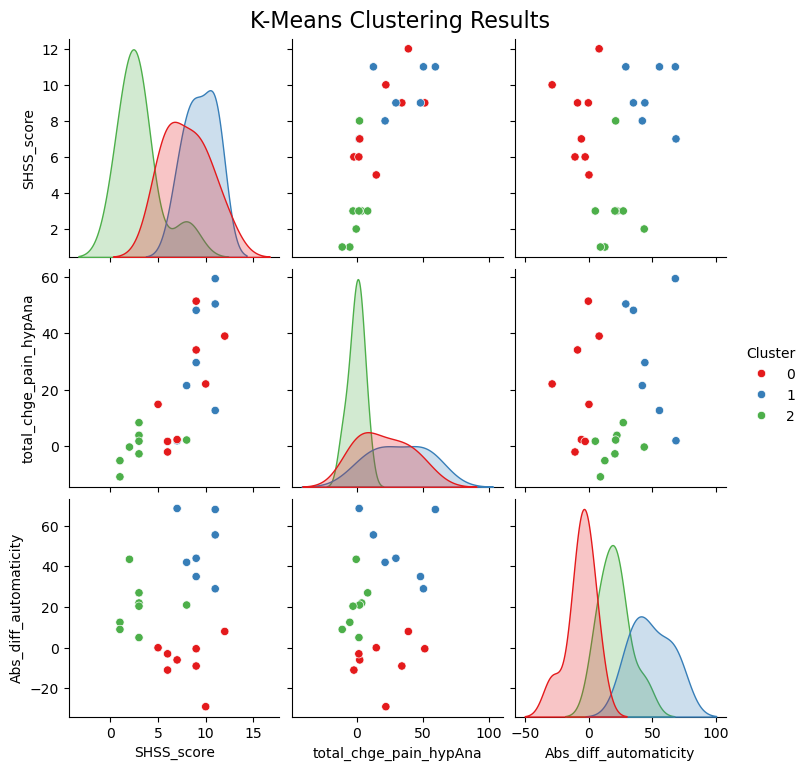

In [62]:
from sklearn.cluster import KMeans
import seaborn as sns

# Select behavioral variables for clustering
behavioral_data = df[['SHSS_score', 'total_chge_pain_hypAna', 'Abs_diff_automaticity']]

# Run K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(behavioral_data)

# Plot clusters
sns.pairplot(df, vars=behavioral_data.columns, hue='Cluster', palette='Set1')
plt.suptitle('K-Means Clustering Results', y=1.02, fontsize=16)
plt.show()


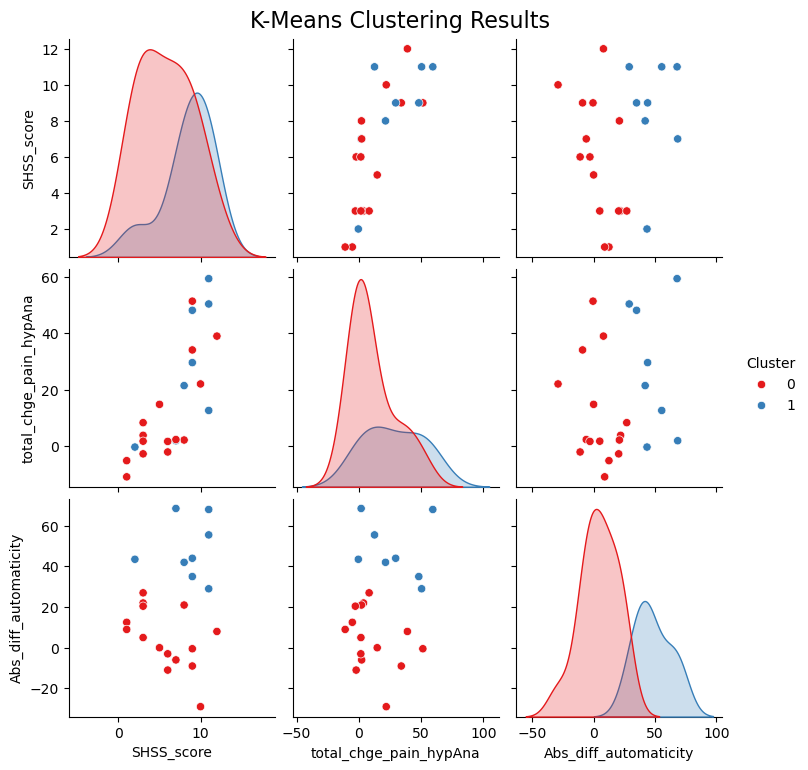

In [59]:
from sklearn.cluster import KMeans
import seaborn as sns

# Select behavioral variables for clustering
behavioral_data = df[['SHSS_score', 'total_chge_pain_hypAna', 'Abs_diff_automaticity']]

# Run K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(behavioral_data)

# Plot clusters
sns.pairplot(df, vars=behavioral_data.columns, hue='Cluster', palette='Set1')
plt.suptitle('K-Means Clustering Results', y=1.02, fontsize=16)
plt.show()


### Save new behavioral dataframe

In [75]:
df

,SHSS_score,mean_VAS_Nana_int,mean_VAS_ana_int,mean_VAS_Nhyper_int,mean_VAS_hyper_int,mean_VAS_Nana_UnP,mean_VAS_ana_UnP,mean_VAS_Nhyper_UnP,mean_VAS_hyper_UnP,raw_change_ANA,...,Chge_hypnotic_depth,Mental_relax_absChange,Automaticity_post_ind,Abs_diff_automaticity,SHSS_groups,auto_groups,mean_VAS_Nana,mean_VAS_Ana,mean_VAS_NHyper,mean_VAS_Hyper
APM20,11.0,58.666667,24.0,50.0,65.5,32.666667,7.0,33.0,58.0,-30.166667,...,59.5,-33.5,57.0,29.0,2,1,45.666667,15.5,41.5,61.75
APM43,6.0,74.0,78.5,65.666667,65.5,77.333333,78.5,73.0,74.5,2.833333,...,0.0,-12.5,40.0,-11.0,1,0,75.666667,78.5,69.333333,70.0
APM26,3.0,83.333333,80.0,78.333333,80.5,86.333333,86.0,88.333333,90.0,-1.833333,...,14.0,-25.5,29.0,22.0,0,1,84.833333,83.0,83.333333,85.25
APM33,3.0,38.0,30.0,38.0,36.5,38.333333,32.5,37.333333,41.5,-6.916667,...,33.5,4.0,44.0,27.0,0,1,38.166667,31.25,37.666667,39.0
APM12,11.0,71.0,73.0,63.666667,78.0,72.0,73.5,64.666667,79.0,1.75,...,81.5,-19.0,61.5,55.5,2,2,71.5,73.25,64.166667,78.5
APM07,8.0,60.666667,60.0,60.333333,61.5,60.333333,61.0,63.0,66.0,0.0,...,23.0,-32.0,78.5,21.0,1,1,60.5,60.5,61.666667,63.75
APM38,11.0,53.0,38.5,10.333333,53.0,56.333333,48.5,13.666667,67.5,-11.166667,...,78.0,-3.0,70.0,68.0,2,2,54.666667,43.5,12.0,60.25
APM42,9.0,48.333333,27.0,34.0,69.0,47.666667,20.0,29.666667,48.5,-24.5,...,30.0,-3.5,8.0,-0.5,2,0,48.0,23.5,31.833333,58.75
APM06,5.0,63.333333,68.0,84.0,95.5,69.333333,68.0,72.666667,94.0,1.666667,...,39.0,-24.5,0.0,0.0,1,0,66.333333,68.0,78.333333,94.75
APM27,10.0,35.666667,17.0,50.333333,48.5,47.0,41.0,77.333333,98.5,-12.333333,...,27.5,-19.0,5.5,-29.0,2,0,41.333333,29.0,63.833333,73.5


In [82]:
df.to_csv(os.path.join(project_dir, 'results/behavioral', 'behavioral_data_cleaned.csv'), index = True)

Load data